<a href="https://colab.research.google.com/github/JuanARojasA/Ciencia_Datos/blob/master/EjemploCNN/script_cnn_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Permite importar el drive a Colab
from google.colab import drive
drive.mount('/content/drive')

# Esta linea se usa para importar el repositorio de Github
!git clone https://github.com/JuanARojasA/Ciencia_Datos.git
!ls

Mounted at /content/drive
fatal: destination path 'Ciencia_Datos' already exists and is not an empty directory.
Ciencia_Datos  drive  gdrive  sample_data


In [0]:
# -*- coding: utf-8 -*-

# Librerías propias para las redes neuronales por convolución
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import backend as K
from keras.utils import to_categorical

# Libreria para arreglos multidimensionales
import numpy as np


# Librería para graficar 
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import itertools

# Librerías para obtener métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Sección nueva

In [0]:
# Preparación del entorno para trabajar sobre GPU
K.tensorflow_backend._get_available_gpus()
config = tf.ConfigProto( device_count = {'GPU': 1} )
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [0]:
# Rutas de los conjuntos de imagenes
# Estas rutas son válidas si importan a Colab su drive y si han puesto la caperta "final" en la raiz de su drive
ruta_dataset_entrenamiento = "/content//Ciencia_Datos/EjemploCNN/training"
ruta_dataset_prueba = "/content//Ciencia_Datos/EjemploCNN/test"
ruta_dataset_validacion = "/content//Ciencia_Datos/EjemploCNN/validation"
num_classes = 3

In [0]:
# Preprocesamiento
#Data aumentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
#Load Data
train_generator = train_datagen.flow_from_directory(ruta_dataset_entrenamiento,target_size=(80,80),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)
test_generator = test_datagen.flow_from_directory(ruta_dataset_prueba,target_size=(80,80),color_mode='rgb',batch_size=1,class_mode='categorical',shuffle=False)
validation_generator = validation_datagen.flow_from_directory(ruta_dataset_validacion,target_size=(80,80),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)


Found 1540 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


## Modelo
    Se presenta el diseño del modelo de la red neuronal por convolución tomado de: https://www.kaggle.com/byrachonok/keras-for-search-ships-in-satellite-image. Lo que se muestra son las capas y como ir añadiendo cada una de ellas y sus hiperparámetros.
    
    Después, se muestra la compilación del modelo, definiendo la función de pérdida, el optimizador y las métricas.
    
    En la parte de entrenamiento, se define funciones de callbacks, en este caso EarlyStopping y ModelCheckpoint. Una vez definidas estas funciones, se realiza el entrenamiento del modelo, con el conjunto de entrenamiento y de validación. Se definen un número de 32 epochs pero al tener el earlystopping se detiene cuando el valor de loss validation no mejora en 4 iteraciones y mediante el modelcheckpoint se guarda ese modelo. Posterior a esto, se presenta dos gráficas, una de ella presenta la función de pérdida en entrenamiento y validación y la otra la métrica de accuracy en fase de entrenamiento y validación.
    

In [0]:

#Design
# Se define como un modelo secuencial
model = Sequential()

# Se añaden las capas y sus hiperparámetros
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# La capa de salida debe tener el mismo número de clases
model.add(Dense(num_classes, activation='softmax'))


In [0]:
#Compilation
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
#Training
# Funciones callbacks
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5), ModelCheckpoint(filepath="/content/Ciencia_Datos/EjemploCNN/model_jupyter.h5", monitor='val_loss', save_best_only=True, verbose=1,mode='min')]


step_size_train=train_generator.n/train_generator.batch_size
step_size_validation=validation_generator.n/validation_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   validation_steps = step_size_validation,
                   epochs=32, callbacks=callbacks)

Epoch 1/32
49/48 [==============================] - 21s 436ms/step - loss: 1.0425 - acc: 0.4159 - val_loss: 0.9035 - val_acc: 0.5861

Epoch 00001: val_loss improved from inf to 0.90354, saving model to /content/Ciencia_Datos/EjemploCNN/model_jupyter.h5
Epoch 2/32
49/48 [==============================] - 20s 413ms/step - loss: 0.8380 - acc: 0.6122 - val_loss: 0.9870 - val_acc: 0.4222

Epoch 00002: val_loss did not improve from 0.90354
Epoch 3/32
49/48 [==============================] - 21s 422ms/step - loss: 0.7312 - acc: 0.6983 - val_loss: 0.8448 - val_acc: 0.6389

Epoch 00003: val_loss improved from 0.90354 to 0.84476, saving model to /content/Ciencia_Datos/EjemploCNN/model_jupyter.h5
Epoch 4/32
49/48 [==============================] - 21s 421ms/step - loss: 0.6709 - acc: 0.7310 - val_loss: 0.8630 - val_acc: 0.5889

Epoch 00004: val_loss did not improve from 0.84476
Epoch 5/32
49/48 [==============================] - 21s 420ms/step - loss: 0.5774 - acc: 0.7851 - val_loss: 0.6574 - val

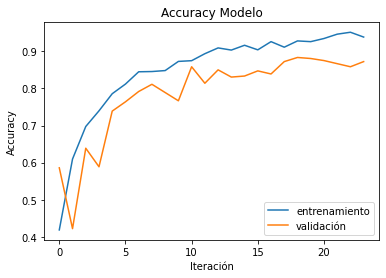

In [37]:
# Gráfica de la métrica de precisión
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='lower right')
plt.show()


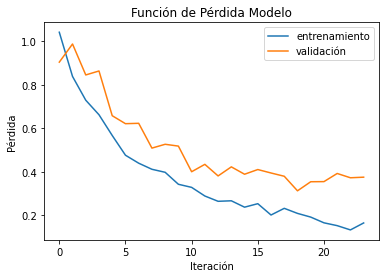

In [39]:
# Gráfica de la función de pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de Pérdida Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='upper right')
plt.show()

In [0]:
# Load Model
model_loaded = load_model("/content/Ciencia_Datos/EjemploCNN/model_jupyter.h5")

In [42]:
step_size_test=test_generator.n/test_generator.batch_size
result_evaluate =  model_loaded.evaluate_generator(test_generator,step_size_test,verbose=1)
print(result_evaluate)

300/300 [==============================] - 2s 7ms/step
[0.3330663373866153, 0.8833333333333333]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


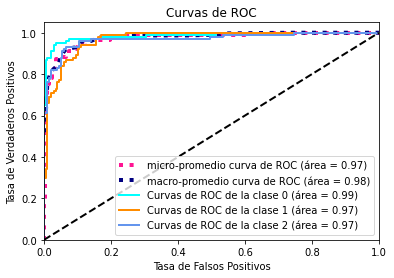

In [43]:
y_pred_prob =  model_loaded.predict_generator(test_generator, steps= step_size_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
test_labels_one_hot = to_categorical(test_generator.classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot((fpr["micro"]), (tpr["micro"]),
         label='micro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curvas de ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas de ROC')
plt.legend(loc="lower right")
plt.show()

In [44]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_generator.classes, y_pred_classes)
print('Accuracy: %f' % accuracy)


Accuracy: 0.883333


In [45]:
# precision tp / (tp + fp)
precision = precision_score(test_generator.classes, y_pred_classes, average = 'macro')
print('Precision:', precision)


Precision: 0.8845575982368435


In [46]:
# recall: tp / (tp + fn)
recall = recall_score(test_generator.classes, y_pred_classes, average = 'macro')
print('Recall: %f' % recall)

Recall: 0.883333


In [47]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_generator.classes, y_pred_classes, average = 'macro')
print('F1 score: %f' % f1)

F1 score: 0.882776


In [48]:
# kappa
kappa = cohen_kappa_score(test_generator.classes, y_pred_classes)
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.825000


In [49]:
# confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred_classes)
print(matrix)

[[94  2  4]
 [ 7 89  4]
 [ 5 13 82]]


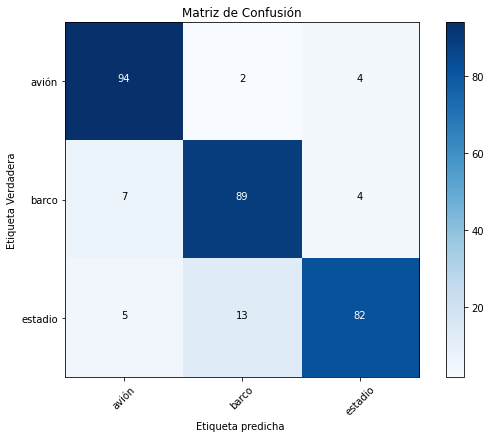

In [50]:
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest',cmap=cmap)
plt.title("Matriz de Confusión")
plt.colorbar()
target_names = ['avión', 'barco', 'estadio']

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)



thresh = matrix.max() / 1.5
matrix.max() / 2
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, "{:,}".format(matrix[i, j]),horizontalalignment="center",color="white" if matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta predicha ')
plt.show()